# Figures

In here, all the main figures are plotted

In [ ]:
import itertools
import os

import numpy as np
import pandas as pd
from ridgeplot import ridgeplot

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'notebook'
from graphmodex import plotlymodex

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import font_manager
import matplotlib as mpl

from bumplot import bumplot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp 
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

from statsforecast import StatsForecast

# Data & Config

In [8]:
# ===============================
# CONFIG
# ===============================
steps_per_day = 8
two_year_steps = 2 * 365 * steps_per_day
target_windows = 30

FREQ = '3h'
SEASON_LENGTH = 8 

pollutants_dict = {
        'go3': {
            'scaler': 1e8
        },
        'no2': {
            'scaler': 1e10
        },
        'pm10': {
            'scaler': 1e9
        },
        'pm2p5': {
            'scaler': 1e9
        },
    }
experiments_dict = {
    '1 days': {
        'horizon': 8*1,
        'step_size': max(8*1, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '7 days': {
        'horizon': 8*7,
        'step_size': max(8*7, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '14 days': {
        'horizon': 8*14,
        'step_size': max(8*14, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '30 days': {
        'horizon': 8*30,
        'step_size': 8*30,
        'windows': two_year_steps // (8*30),  # 24
    },
}

database_full = pd.read_csv(r'.\Results\RQ1\full\go3_1days.csv')
database_full = database_full.query("NHITS.notna()")

metrics = pd.read_csv(r'.\Results\RQ1\metrics.csv')

# Forecasting

In [102]:
def plot_pollutant_forecasting(
        poll='go3',
        h=1,
        uid=0,
        models={
            'NHITS': "#287eb8",
            'NBEATS-G': "#72a549",
            'NBEATS-I': "#d4bc34",
            'LightGBM': "#6c34d4",
            'Naive': "#d43f34",
            'SeasonalNaive': "#d4347f",
        },
        horizon=None,  # Adicionando o parâmetro horizon
        y_range=None,
        x_range=None,
        y_anchor=0.2,
    ):

    series = pd.read_parquet(rf'.\Results\RQ1\full\{poll}.parquet')

    df = pd.read_csv(rf'.\Results\RQ1\full\{poll}_{str(h)}days.csv')
    # df = df.query("NHITS.notna()")
    df = df.rename(columns={'valid_time': 'ds'})
    df = df.astype({
        'ds': 'datetime64[ns]',
        'cutoff': 'datetime64[ns]',
    })

    cutoffs = df['cutoff'].unique() 

    # ==================================================
    # REAL SERIE
    # ==================================================
    fig = go.Figure()

    pollutant_filt = series.copy().query(
        "ds >= '2022-06-01' and unique_id == @uid"
    )

    fig.add_trace(
        go.Scatter(
            x=pollutant_filt['ds'],
            y=pollutant_filt['y'],
            mode='lines',
            line=dict(color='black', width=3),
            name='Real'
        )
    )

    # ==================================================
    # MODELS — ONE WINDOW PER CUTOFF
    # ==================================================
    for model, color in models.items():
        show_legend_ = True
        for cutoff in cutoffs:

            df_fold = df.query(
                "unique_id == @uid and cutoff == @cutoff"
            )

            if df_fold.empty:
                continue

            # Linha da previsão (segmento independente)
            fig.add_trace(
                go.Scatter(
                    x=df_fold['ds'],
                    y=df_fold[model],
                    mode='lines',
                    line=dict(color=color, width=3),
                    marker=dict(color=color, size=5),
                    opacity=0.9,
                    name=model,
                    showlegend=show_legend_
                )
            )

            show_legend_ = False

    # ==================================================
    # CUTOFFS VERTICAL LINES
    # ==================================================
    for cutoff in cutoffs:
        fig.add_vline(
            x=cutoff + pd.Timedelta(hours=3),
            line_width=1,
            line_dash="dot",
            line_color="black",
            opacity=0.5
        )
        if horizon is not None:  # Usando o horizonte fornecido como parâmetro
            fig.add_vline(
                x=cutoff + pd.Timedelta(hours=3 * horizon),
                line_width=1,
                line_dash="dot",
                line_color="black",
                opacity=0.5
            )

    # ==================================================
    # FINAL LAYOUT
    # ==================================================
    plotlymodex.main_layout(
        fig, width=1200, height=600,
        x=r"$\mathrm{time_{\ freq: 3 h}}$",
        y=r"$\mathrm{kg\ kg^{-1}}$",
        title='Pollutant Forecasting | Cross-Validation Windows',
        x_range=x_range, y_range=y_range
    )

    fig.update_layout(
        legend_title_text='Series',
        hovermode='x unified',

        # Fonte global
        font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        ),

        # Eixo X
        xaxis=dict(
            showgrid=False, zeroline=False,
            title_font=dict(family="Times New Roman"),
            tickfont=dict(family="Times New Roman")
        ),

        # Eixo Y
        yaxis=dict(
            zeroline=False,
            title_font=dict(family="Times New Roman"),
            tickfont=dict(family="Times New Roman")
        ),
    )

    fig.update_layout(
        # Margens bem mais compactas
        margin=dict(
            l=60,
            r=10,
            t=60, 
            b=50
        ),

        # Título mais compacto
        title=dict(
            y=0.97,
            yanchor='top'
        )
    )

    fig.update_layout(
        legend=dict(
            x=0.01,      # esquerda
            y=y_anchor,  # topo
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.7)',  # opcional
            bordercolor='black',              # opcional
            borderwidth=2                     # opcional
        )
    )

    return fig

In [103]:
# Exemplo de chamada da função para um dado modelo e cutoff
models = {
    'NHITS': "#c4ad30",
    # 'NBEATS-G': "#c4ad30",
    # 'NBEATS-I': "#c4ad30",
    # 'LightGBM': "#6aa040",
    # 'XGBoost': "#6aa040",
    # 'RandomForest': "#6aa040",
    # 'GRU': "#e01f66",
    # 'LSTM': "#e01f66",
    # 'Informer': "#e01f66",
    # 'Arima': "#5cc8e6",
    # 'Theta': "#5cc8e6",
    # 'ETS': "#5cc8e6",
    # 'Naive': "#c9c9c9",
    # 'SeasonalNaive-8': "#c9c9c9",
    # 'SeasonalNaive-56': "#c9c9c9",
}

# Chamada da função com o ID único, cutoffs e modelos
plot_pollutant_forecasting(
    poll='go3',
    h=7,
    uid=104,
    models=models,
    x_range=['2024-11-14', '2024-12-31'],
    y_range=[0, 70e-9],
    y_anchor=0.2,
)

## ACF & PACF

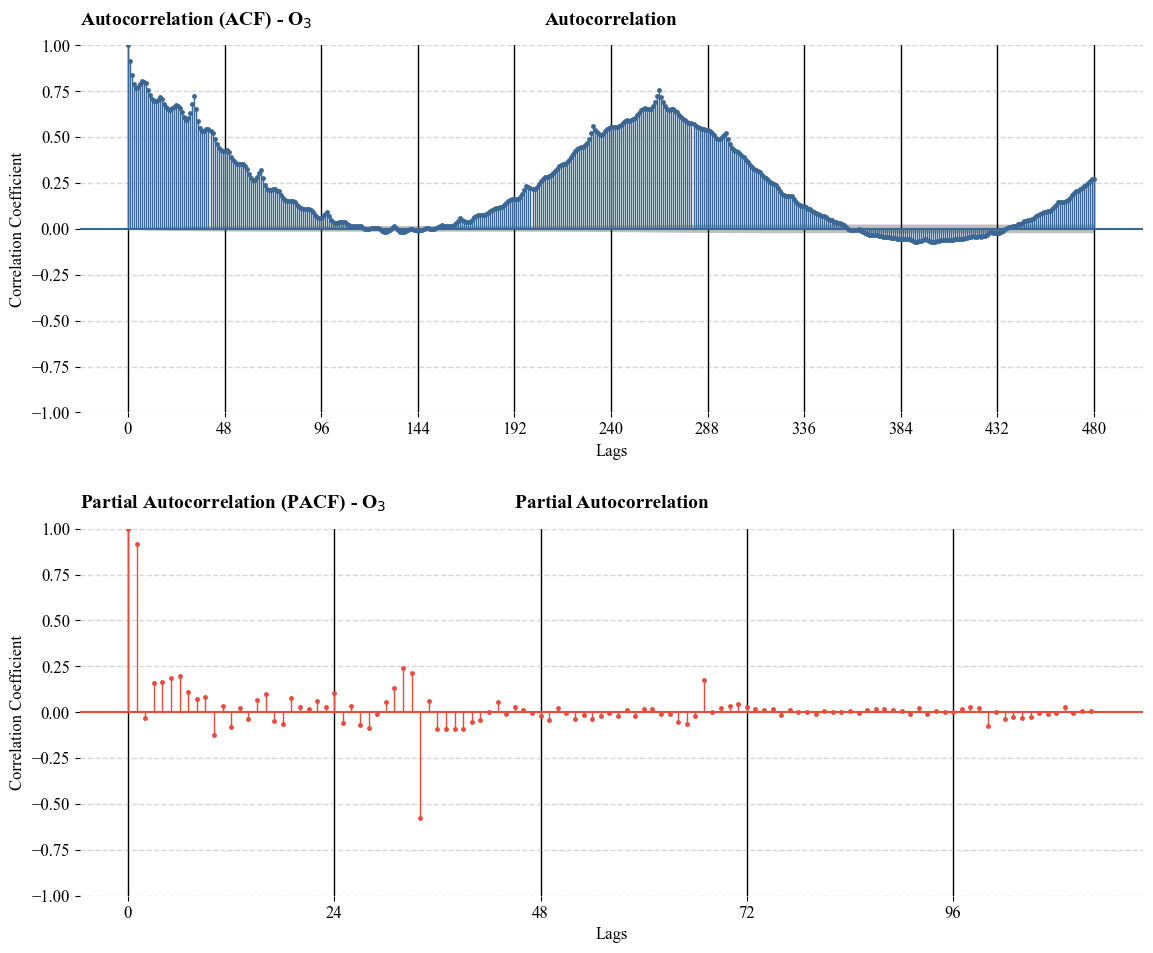

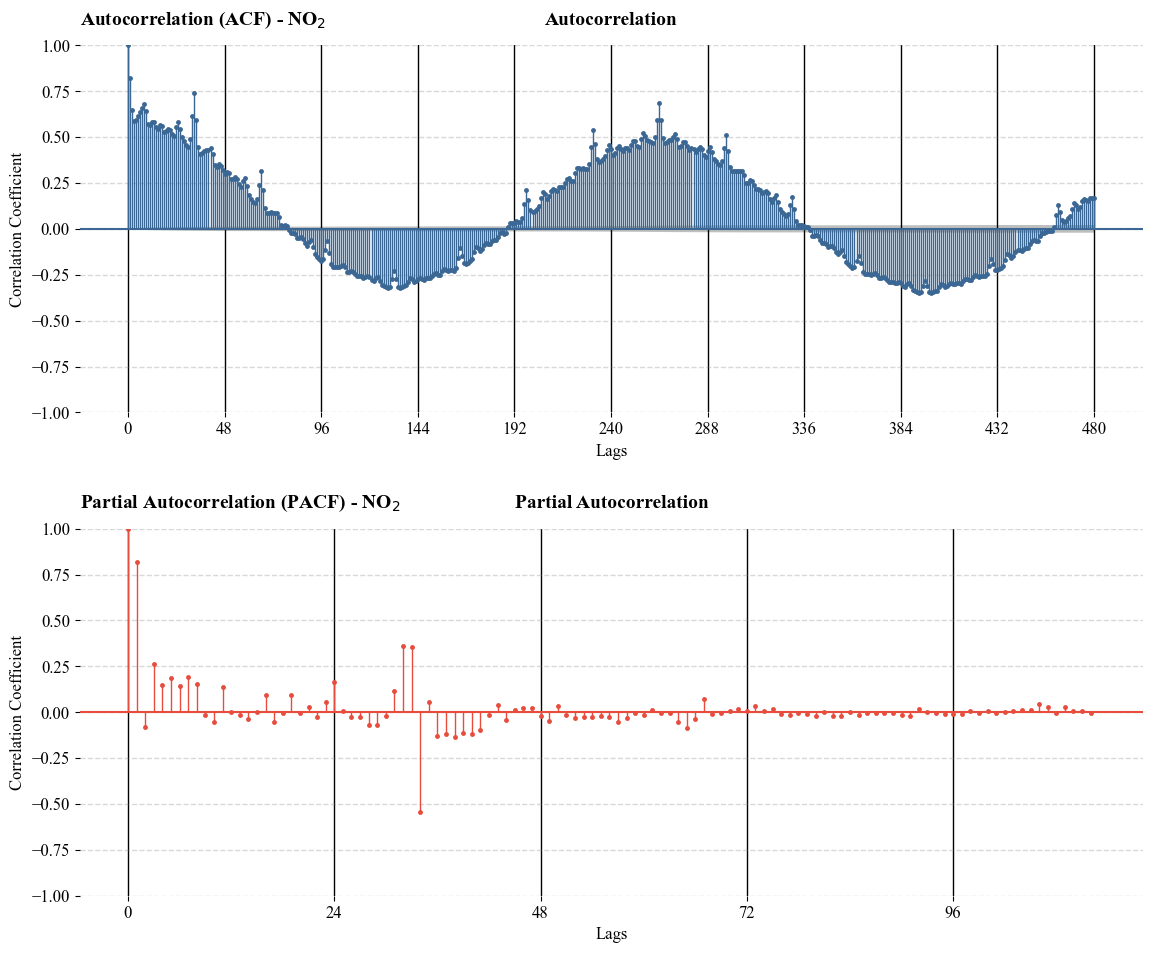

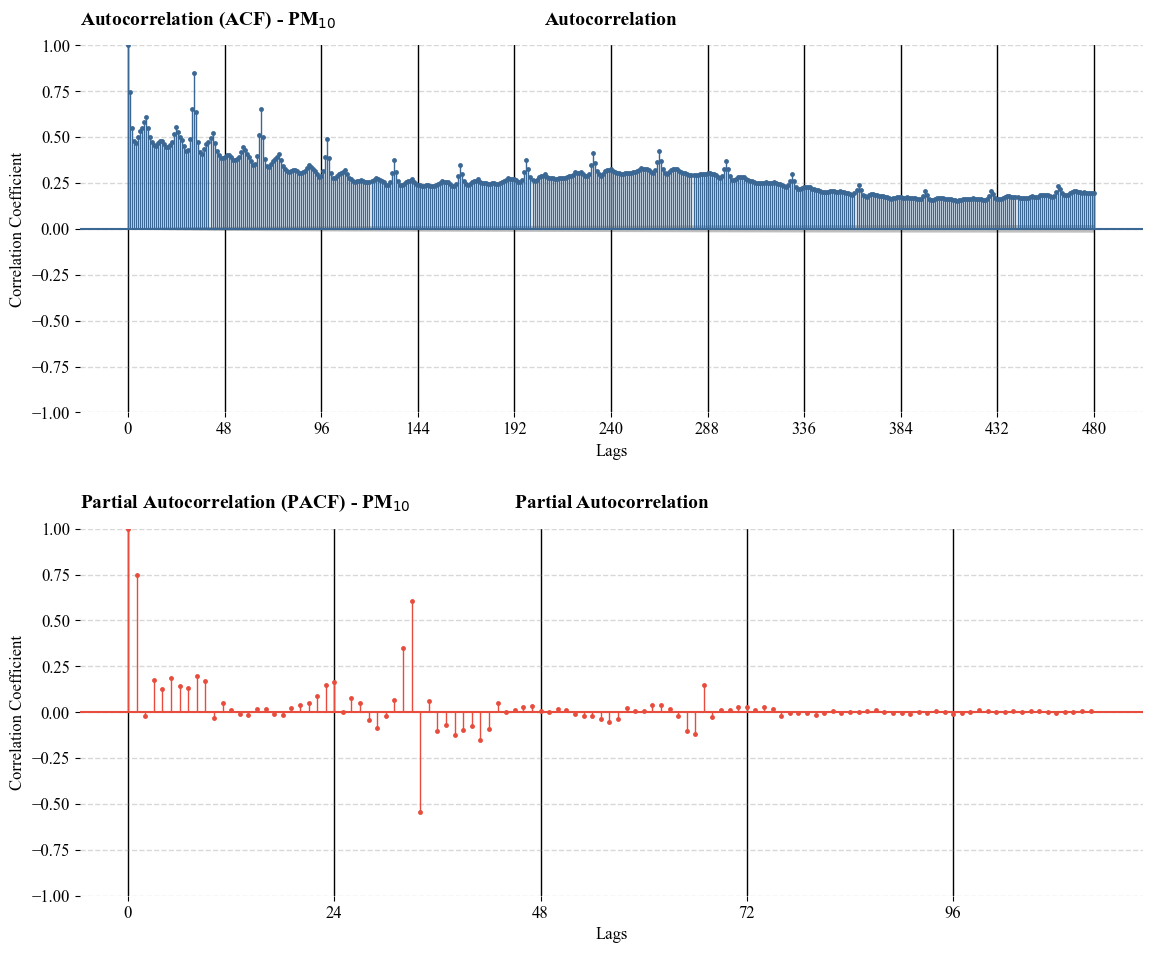

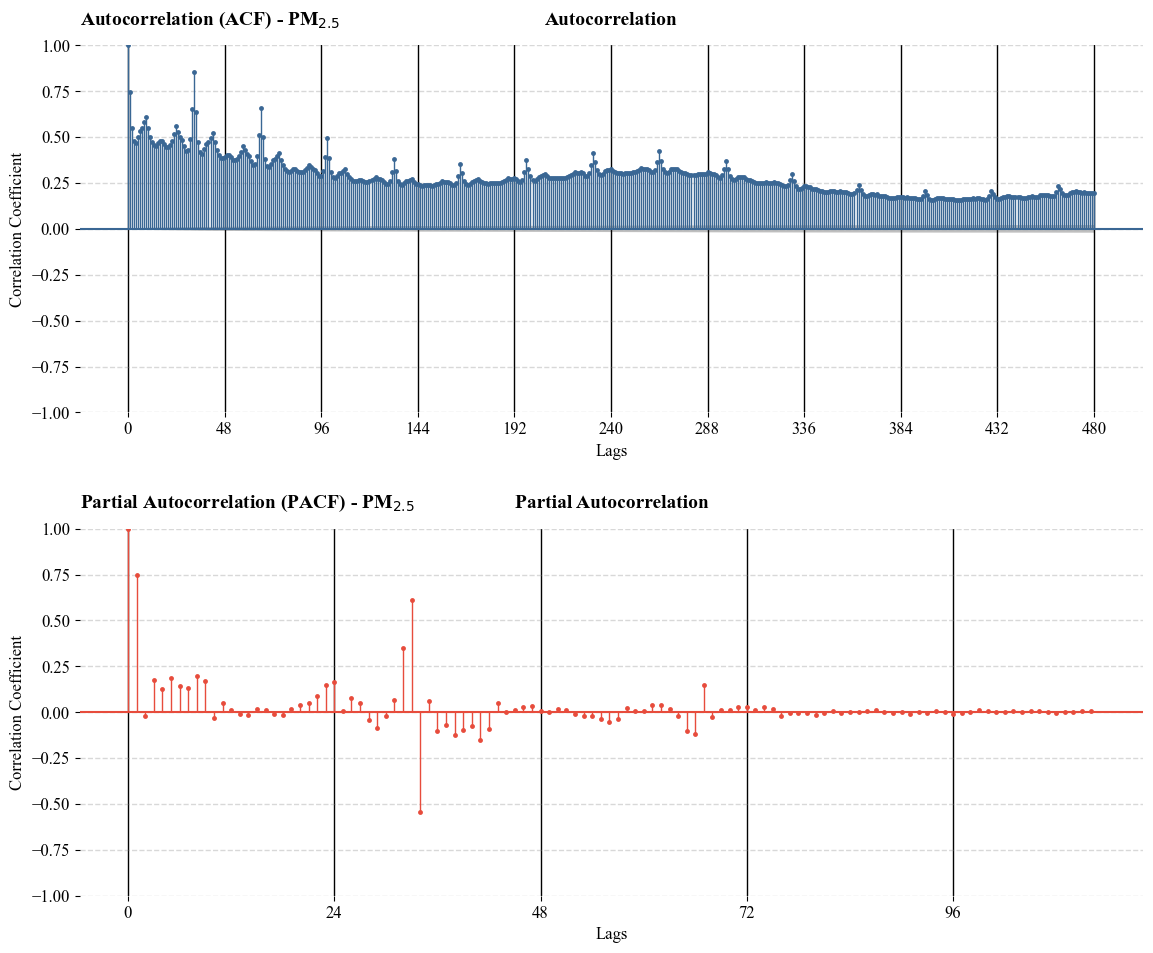

In [31]:
def plot_acf_pacf_publication(df, pollutant_name, lags_acf=8*60, lags_pacf=8*14, save_path=None):
    """
    Gera gráficos de ACF e PACF em padrão de publicação A1.
    """
    # 1. Configuração de Estilo (Consistente e de alto contraste)
    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 12,
        "axes.edgecolor": "#000000",
        "axes.labelcolor": "#000000",
        "xtick.color": "#000000",
        "ytick.color": "#000000",
        "text.color": "#000000",
        "axes.titlesize": 14,
        "axes.titleweight": "bold"
    })

    # Dicionário de nomes formatados para o título (LaTeX)
    display_names = {
        "no2": r"NO$_2$",
        "pm10": r"PM$_{10}$",
        "pm2p5": r"PM$_{2.5}$",
        "go3": r"O$_{3}$",
    }
    
    label_pol = display_names.get(pollutant_name.lower(), pollutant_name.upper())
    
    # Preparação dos dados (Assumindo que o filtro de data já foi feito ou deve ser feito aqui)
    # Se o seu df já vier filtrado, pode remover o .query
    data_series = df.query("ds.between('2015-01-01', '2022-12-31')")["y"]

    # 2. Criação da Figura
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    v_params_acf = {"colors": "#3a6794", "linewidth": 1.0, "alpha": 1.0}
    v_params_pacf = {"colors": "#e74c3c", "linewidth": 1.0, "alpha": 1.0}

    # --- Plot ACF ---
    plot_acf(data_series, lags=lags_acf, ax=ax1, 
             color="#3a6794", 
             vlines_kwargs=v_params_acf,
             alpha=0.05)
    ax1.set_title(f"Autocorrelation (ACF) - {label_pol}", loc='left', pad=15)

    # --- Plot PACF ---
    plot_pacf(data_series, lags=lags_pacf, ax=ax2, 
              color="#e74c3c", 
              vlines_kwargs=v_params_pacf,
              alpha=0.05)
    ax2.set_title(f"Partial Autocorrelation (PACF) - {label_pol}", loc='left', pad=15)

    # 3. Refinamento de Layout
    for ax in [ax1, ax2]:
        ax.spines[["top", "right"]].set_visible(False)
        ax.spines[["left", "bottom"]].set_edgecolor('black')
        ax.spines[["left", "bottom"]].set_linewidth(1.0)
        
        ax.grid(True, axis='y', linestyle='--', alpha=0.3, color='gray')
        
        ax.set_xlabel("Lags", color='black')
        ax.set_ylabel("Correlation Coefficient", color='black')
        
        for line in ax.get_lines():
            line.set_markersize(3.5)
            line.set_markeredgewidth(0)

    # Ajuste dos Ticks do eixo X (Dinâmico baseado no número de lags)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=48))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=12 if lags_pacf <= 100 else 24))

    plt.tight_layout(pad=2.0)

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white')
    
    return fig, (ax1, ax2)

for pol_ in ['go3', 'no2', 'pm10', 'pm2p5']:
    series = pd.read_parquet(rf'.\Results\RQ1\full\{pol_}.parquet')
    fig, axs = plot_acf_pacf_publication(series, f"{pol_}", save_path=f"acf_pacf_{pol_}.png")
    plt.show()

# **RQ1**

## sMAPE Ridge

In [386]:
# Version with Gradient

def plot_ridge_metrics(h : str = '30', metric: str = 'sMAPE', agg_func: str = 'median'):

    # ===============================
    # DATA PREPARATION
    # ===============================

    df_plot = metrics.dropna(subset=[metric])

    median_smape = (
        df_plot
        .query(f"horizon == '{h}days'")
        .groupby("model")[metric]
        .agg(agg_func)
        .sort_values()
    )

    ordered_models = median_smape.index.tolist()

    samples = [
        df_plot.loc[df_plot["model"] == m, metric].values
        for m in ordered_models
    ]

    labels = ordered_models


    # ===============================
    # RIDGEPLOT
    # ===============================

    fig = ridgeplot(samples=samples, labels=labels)

    for tr in fig.data:
        tr.showlegend = False

    plotlymodex.main_layout(
        fig,
        title=f"Distribution of {h}-Day-Ahead {metric} by Model (Ordered by {agg_func.capitalize()} Performance)",
        width=1000,
        height=700,
        x=f"{metric}↓",
        y=None
    )

    fig.update_layout(font=dict(family="Times New Roman", size=16))


    # ===============================
    # CUSTOM Y-AXIS LABELS
    # ===============================

    yvals = list(fig.layout.yaxis.tickvals)

    fig.update_yaxes(showticklabels=False)

    NAME_SHIFT = 0
    MU_SHIFT = -15

    for y, m in zip(yvals, ordered_models):

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{m}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=16),
            yshift=NAME_SHIFT
        )

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{agg_func.capitalize()} = {median_smape[m]:.3f}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=12),
            yshift=MU_SHIFT
        )

    fig.update_layout(
        margin=dict(l=140, r=40, t=50, b=60),
        title=dict(y=0.97, yanchor="top")
    )


    # ===============================
    # MODEL FAMILIES
    # ===============================

    neural_models = ["NBEATS-I", "NBEATS-G", "NHITS"]
    ml_models = ["LightGBM", "RandomForest", "XGBoost"]
    stat_models = ["Arima", "ETS", "Theta"]
    benchmark_models = ["Naive", "SeasonalNaive-8", "SeasonalNaive-56"]
    dl_models = ["GRU", "LSTM", "Informer"]


    # ===============================
    # COLOR GRADIENT MAP
    # ===============================

    family_gradients = {
        "neural": ["#D62121", "#ECD449", "#ECD449"],
        "ml": ["#00B17A", "#3676AA", "#6D2DA8"],
        "stat": ["#BD5CE4", "#38C4DD", "#38C4DD"],
        "benchmark": ["#707070", "#E7E7E7", "#E7E7E7"],
        "dl": ["#DD7DCD", "#CF5C9F", "#DA4444"],
    }
  
 
    # ===============================
    # FAMILY IDENTIFICATION
    # ===============================

    def get_family(model):
        if model in neural_models:
            return "neural"
        elif model in ml_models:
            return "ml"
        elif model in stat_models:
            return "stat"
        elif model in benchmark_models:
            return "benchmark"
        elif model in dl_models:
            return "dl"
        else:
            return None


    def build_colorscale(anchor_colors):
        colors = plotlymodex.list_colors(
            n=20,
            colors=anchor_colors,
            weights=[0, 0.5, 1]
        )
        return [[i/(len(colors)-1), c] for i, c in enumerate(colors)]


    # ===============================
    # APPLY GRADIENTS
    # ===============================

    for trace in fig.data:

        if trace.fill == "tonexty":

            model = trace.name
            family = get_family(model)

            if family is not None:

                anchors = family_gradients[family]

                trace.fillgradient = dict(
                    type="horizontal",
                    colorscale=build_colorscale(anchors)
                )

    fig.update_xaxes(
        showgrid=True,
        gridwidth=0.4,
        gridcolor="rgba(0,0,0,0.07)"
    )
    fig.update_xaxes(range=[0, 1.5])
    fig.update_yaxes(showgrid=False)

    for trace in fig.data:
        trace.line.width = 1

    fig.show()

In [387]:
# Defined Colors Version

def plot_ridge_metrics(h: str = '30', metric: str = 'sMAPE', agg_func: str = 'median'):

    # ===============================
    # DATA PREPARATION
    # ===============================

    df_plot = metrics.dropna(subset=[metric])

    median_smape = (
        df_plot
        .query(f"horizon == '{h}days'")
        .groupby("model")[metric]
        .agg(agg_func)
        .sort_values()
    )

    ordered_models = median_smape.index.tolist()

    samples = [
        df_plot.loc[df_plot["model"] == m, metric].values
        for m in ordered_models
    ]

    labels = ordered_models


    # ===============================
    # RIDGEPLOT
    # ===============================

    fig = ridgeplot(samples=samples, labels=labels)

    for tr in fig.data:
        tr.showlegend = False

    plotlymodex.main_layout(
        fig,
        title=f"Distribution of {h}-Day-Ahead {metric} by Model (Ordered by {agg_func.capitalize()} Performance)",
        width=1000,
        height=700,
        x=f"{metric}↓",
        y=None
    )

    fig.update_layout(font=dict(family="Times New Roman", size=16))


    # ===============================
    # CUSTOM Y-AXIS LABELS
    # ===============================

    yvals = list(fig.layout.yaxis.tickvals)

    fig.update_yaxes(showticklabels=False)

    NAME_SHIFT = 0
    MU_SHIFT = -15

    for y, m in zip(yvals, ordered_models):

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{m}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=16),
            yshift=NAME_SHIFT
        )

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{agg_func.capitalize()} = {median_smape[m]:.3f}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=12),
            yshift=MU_SHIFT
        )

    fig.update_layout(
        margin=dict(l=140, r=40, t=50, b=60),
        title=dict(y=0.97, yanchor="top")
    )


    # ===============================
    # MODEL FAMILIES
    # ===============================

    neural_models = ["NBEATS-I", "NBEATS-G", "NHITS"]
    ml_models = ["LightGBM", "RandomForest", "XGBoost"]
    stat_models = ["Arima", "ETS", "Theta"]
    benchmark_models = ["Naive", "SeasonalNaive-8", "SeasonalNaive-56"]
    dl_models = ["GRU", "LSTM", "Informer"]


    # ===============================
    # COLOR MAP (Correção no formato da cor com transparência)
    # ===============================

    color_map = {
        'Neural': "rgba(233, 163, 58, 0.67)",  
        'ML': 'rgba(106, 160, 64, 0.67)',      
        'Stats': 'rgba(92, 200, 230, 0.67)',   
        'Benchmark': 'rgba(201, 201, 201, 0.67)',
        'DL': 'rgba(224, 31, 102, 0.5)',
        'Other': 'rgba(0, 0, 0, 1)'             
    }

    # ===============================
    # FAMILY IDENTIFICATION
    # ===============================

    def get_family(model):
        if model in neural_models:
            return "Neural"
        elif model in ml_models:
            return "ML"
        elif model in stat_models:
            return "Stats"
        elif model in benchmark_models:
            return "Benchmark"
        elif model in dl_models:
            return "DL"
        else:
            return "Other"


    # ===============================
    # APPLY FIXED COLORS & FILLS
    # ===============================

    for trace in fig.data:
        # 1. Identificamos se o traço é uma curva (possui nome)
        if trace.name is not None:
            model = trace.name
            family = get_family(model)
            family_color = color_map.get(family, color_map["Other"])

            # 2. Forçar contorno preto e largura
            trace.line.color = 'black'
            trace.line.width = 1.5
            
            # 3. Remover o gradiente para que a fillcolor funcione
            if 'fillgradient' in trace:
                trace.fillgradient = None
            
            # 4. Definir preenchimento sólido com a cor da família
            trace.fill = 'toself'
            trace.fillcolor = family_color
            
        else:
            # Estes são os traços da "base" (linhas horizontais pretas)
            # Se você quiser que eles sumam ou fiquem mais sutis:
            trace.line.width = 1
            trace.line.color = 'rgba(0,0,0,0.3)' # Deixa a base semi-transparente

    fig.update_xaxes(
        showgrid=True,
        gridwidth=0.4,
        gridcolor="rgba(0,0,0,0.07)"
    )
    fig.update_xaxes(range=[0, 1.5])
    fig.update_yaxes(showgrid=False)

    for trace in fig.data:
        trace.line.width = 0.8  

    return fig


In [ ]:
# Lista de horizontes que você deseja processar
horizontes = [1, 7, 14, 30]

for h_val in horizontes:
    fig = plot_ridge_metrics(h=h_val, metric='sMAPE', agg_func='median')
    
    # filename = f"ridgeplot_h{h_val}_smape.png"
    # fig.write_image(filename, scale=3)
    # print(f"✅ Salvo: {filename}")
    
    fig.show()

In [ ]:
def plot_horizon_degradation(df_metrics, metric='sMAPE', agg_func='median'):
    # Prepara os dados agrupando por modelo e horizonte
    df_grouped = (
        df_metrics
        .groupby(['model', 'horizon'])[metric]
        .agg(agg_func)
        .reset_index()
    )
    
    # Converte horizonte para numérico se necessário (ex: '30days' -> 30)
    if df_grouped['horizon'].dtype == 'object':
        df_grouped['horizon_num'] = df_grouped['horizon'].str.extract(r'(\d+)').astype(int)

    df_grouped = df_grouped.query("horizon.isin(['1days', '30days'])")

    fig = px.line(
        df_grouped.sort_values('horizon_num'), 
        x='horizon_num', 
        y=metric, 
        color='model',
        markers=True,
        title=f"Degradação da Performance: {metric} vs. Horizonte",
        labels={'horizon_num': 'Horizonte (Dias)', metric: f'{agg_func.capitalize()} {metric}'}
    )
    
    fig.update_layout(template="simple_white", hovermode="x unified")
    return fig

def get_degradation_table(df_metrics, metric='sMAPE'):
    # Agrupa e limpa
    df_res = df_metrics.groupby(['model', 'horizon'])[metric].median().unstack()
    
    # Supõe que as colunas sejam '1days', '7days', '30days', etc.
    # Vamos calcular a diferença percentual entre o menor e o maior horizonte
    horizontes = sorted(df_res.columns, key=lambda x: int(''.join(filter(str.isdigit, x))))
    h_min, h_max = horizontes[0], horizontes[-1]
    
    df_res['Delta_Absoluto'] = df_res[h_max] - df_res[h_min]
    df_res['Degradação_%'] = (df_res[h_max] / df_res[h_min] - 1) * 100
    
    return df_res[['Delta_Absoluto', 'Degradação_%']].sort_values('Degradação_%', ascending=False)

# plot_horizon_degradation(metrics)
get_degradation_table(metrics)

horizon           Delta_Absoluto  Degradação_%
model                                         
LightGBM                0.170109     58.155156
ETS                     0.223363     58.004604
Informer                0.215749     54.636919
Arima                   0.182319     49.537110
Theta                   0.148539     40.919840
NBEATS-G                0.121757     38.578783
NBEATS-I                0.120969     38.059498
NHITS                   0.120277     37.907477
SeasonalNaive-8         0.151312     37.286464
Naive                   0.152693     28.288239
LSTM                    0.093021     26.204579
GRU                     0.071536     19.263813
SeasonalNaive-56        0.069083     13.318839
RandomForest            0.060216     11.443287
XGBoost                 0.037086      6.693715

## Statistics

### Metrics

In [389]:
table_metrics = metrics.copy(deep=True)

table_metrics = (
    metrics
    .groupby(['horizon', 'model'])
    .agg(
        MAE_mean=('MAE', 'mean'),
        MAE_std=('MAE', 'std'),
        RMSE_mean=('RMSE', 'mean'),
        RMSE_std=('RMSE', 'std'),
        sMAPE_mean=('sMAPE', 'mean'),
        sMAPE_std=('sMAPE', 'std'),
    )
    .reset_index()
)

table_metrics["MAE"] = table_metrics.apply(
    lambda x: f"{x['MAE_mean']:.3e} ± {x['MAE_std']:.3e}", axis=1
)

table_metrics["RMSE"] = table_metrics.apply(
    lambda x: f"{x['RMSE_mean']:.3e} ± {x['RMSE_std']:.3e}", axis=1
)

table_metrics["sMAPE"] = table_metrics.apply(
    lambda x: f"{x['sMAPE_mean']:.3f} ± {x['sMAPE_std']:.3f}", axis=1
)

# Agora sim podemos selecionar
final_table = table_metrics[
    ["model", "horizon", "MAE", "RMSE", "sMAPE"]
]

table_metrics = table_metrics.sort_values(
    by=["horizon", "MAE_mean"],
    ascending=[True, True]  # menor MAE primeiro
)

table_metrics = table_metrics.query("horizon == '1days'")[["model", "MAE", "RMSE", "sMAPE"]]
# table_metrics.to_excel(r'metrically.xlsx')
table_metrics

model                    MAE                   RMSE  \
23             NHITS  4.377e-09 ± 4.556e-09  5.242e-09 ± 5.351e-09   
21          NBEATS-G  4.427e-09 ± 4.835e-09  5.290e-09 ± 5.601e-09   
22          NBEATS-I  4.467e-09 ± 4.851e-09  5.332e-09 ± 5.600e-09   
20          LightGBM  4.596e-09 ± 6.358e-09  5.466e-09 ± 7.249e-09   
18          Informer  4.860e-09 ± 5.114e-09  5.727e-09 ± 5.811e-09   
19              LSTM  5.075e-09 ± 5.412e-09  5.932e-09 ± 6.035e-09   
17               GRU  5.165e-09 ± 5.517e-09  6.039e-09 ± 6.181e-09   
15             Arima  5.519e-09 ± 5.772e-09  6.512e-09 ± 6.540e-09   
28             Theta  5.867e-09 ± 6.937e-09  6.819e-09 ± 7.588e-09   
27   SeasonalNaive-8  6.041e-09 ± 7.471e-09  7.175e-09 ± 8.762e-09   
25      RandomForest  6.438e-09 ± 6.877e-09  7.365e-09 ± 7.560e-09   
24             Naive  7.018e-09 ± 7.429e-09  8.227e-09 ± 8.433e-09   
29           XGBoost  7.162e-09 ± 7.523e-09  8.220e-09 ± 8.353e-09   
26  SeasonalNaive-56  7.379e-09 ± 8.480e-09  8.545e-09 ± 9.396e-09   
16               ETS  2.352e-05 ± 1.304e-03  6.223e-05 ± 3.450e-03   

            sMAPE  
23  0.368 ± 0.233  
21  0.367 ± 0.233  
22  0.372 ± 0.240  
20  0.355 ± 0.227  
18  0.426 ± 0.236  
19  0.417 ± 0.251  
17  0.424 ± 0.248  
15  0.453 ± 0.326  
28  0.443 ± 0.283  
27  0.483 ± 0.304  
25  0.560 ± 0.296  
24  0.602 ± 0.372  
29  0.577 ± 0.290  
26  0.575 ± 0.323  
16  0.464 ± 0.307

### Nemenyi

In [390]:
# 1. Criar a matriz de performance (usando MAE como exemplo)
# Cada linha será um "caso de teste" único e cada coluna um modelo
df_pivot = metrics.pivot_table(
    index=['pollutant', 'horizon', 'unique_id', 'cutoff'], 
    columns='model', 
    values='MAE'
)

# 1. Preparação (supondo que df_pivot já foi criado e dropna() executado)
# Vamos resetar o índice e manter apenas as colunas dos modelos
# Isso remove a complexidade do MultiIndex que causou o KeyError
df_clean = df_pivot.reset_index(drop=True)

# 2. Teste de Friedman
stat, p_value = friedmanchisquare(*[df_clean[col] for col in df_clean.columns])
print(f"Estatística de Friedman: {stat:.4f}")
print(f"p-value: {p_value:.4e}")

# 3. Teste de Nemenyi 
# Passando o DataFrame sem o MultiIndex, a biblioteca funciona corretamente
data_nemenyi = sp.posthoc_nemenyi_friedman(df_clean)

# 4. Cálculo dos Ranks para o Diagrama
# rank 1 = menor erro (melhor)
ranks = df_clean.rank(axis=1, ascending=True).mean()

Estatística de Friedman: 59488.2622
p-value: 0.0000e+00



--- Processando Horizonte: 14days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_14days.png


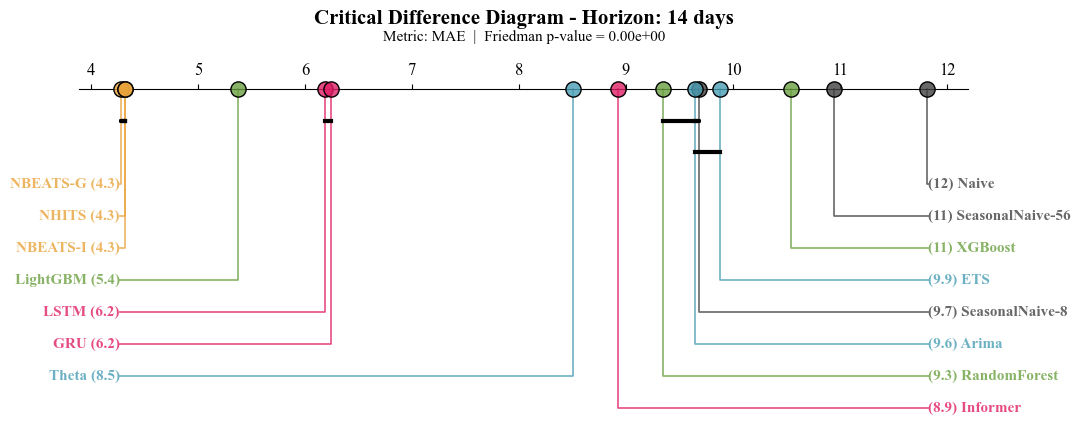


--- Processando Horizonte: 1days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_1days.png


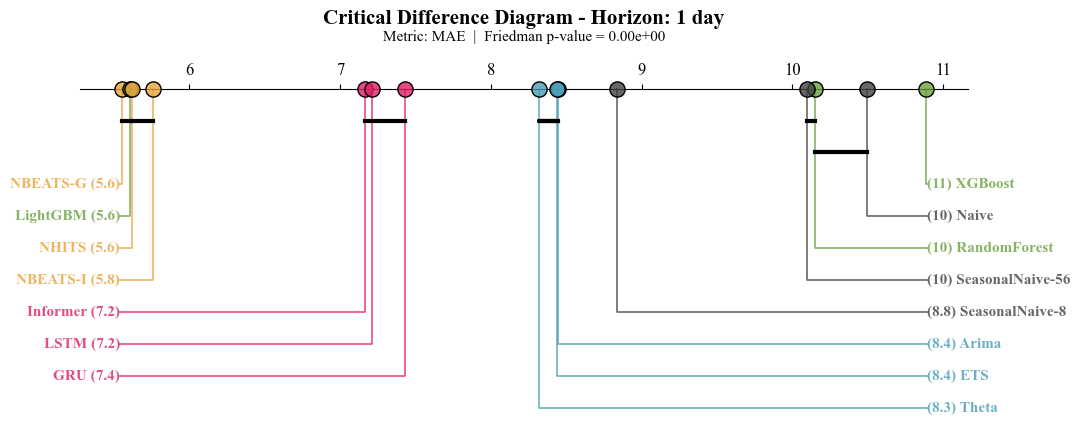


--- Processando Horizonte: 30days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_30days.png


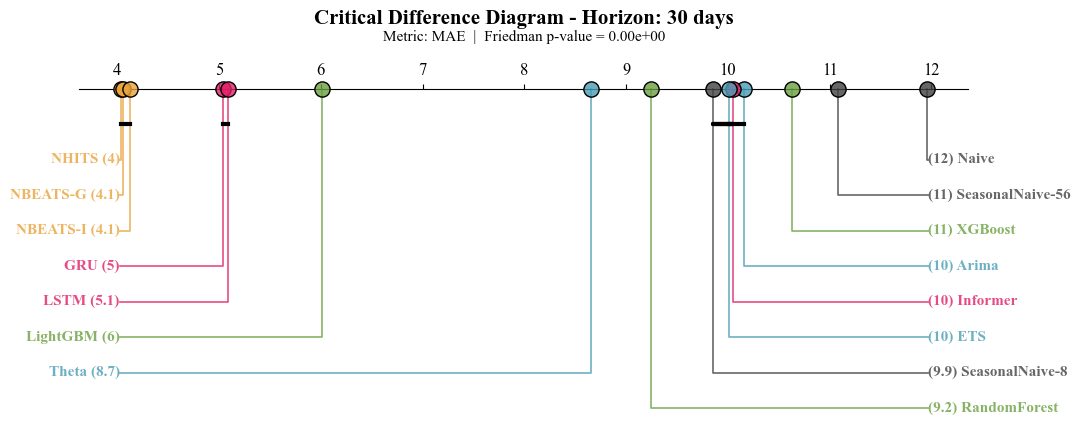


--- Processando Horizonte: 7days ---
Friedman p-value: 0.0000e+00
Salvo: CD_Diagram_MAE_7days.png


In [391]:
# =========================================================
# 1. CONFIGURAÇÃO GLOBAL (Journal Style - Times New Roman)
# =========================================================
plt.rcdefaults()
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 12
})

# Definição das categorias e cores
categories = {
    "Statistical": {"Arima", "ETS", "Theta"},
    "Machine Learning": {"RandomForest", "XGBoost", "LightGBM"},
    "Deep Learning": {"LSTM", "GRU", "Informer"},
    "Neural": {"NHITS", "NBEATS-G", "NBEATS-I"},
    "Benchmark": {"Naive", "SeasonalNaive-8", "SeasonalNaive-56"}
}

color_palette = {
    "Statistical": "#489db4cc", "Machine Learning": "#6aa040cc",
    "Deep Learning": "#e01f66cc", "Neural": "#e9a33acc", "Benchmark": "#414141cc"
}

# =========================================================
# 2. LOOP POR HORIZONTE
# =========================================================
horizontes = metrics['horizon'].unique()

for hor in horizontes:
    print(f"\n--- Processando Horizonte: {hor} ---")
    
    # Filtrar dados para o horizonte específico
    df_h = metrics[metrics['horizon'] == hor]
    
    # Pivotar: cada linha é um par (poluente, estacao, cutoff)
    df_pivot = df_h.pivot_table(
        index=['pollutant', 'unique_id', 'cutoff'], 
        columns='model', 
        values='MAE'
    ).dropna()

    if df_pivot.empty:
        continue

    # --- SOLUÇÃO PARA O KEYERROR ---
    # 1. Resetamos o índice para transformar pollutant, unique_id e cutoff em colunas normais
    # 2. Mas o Nemenyi precisa apenas da matriz de valores (modelos nas colunas)
    # Portanto, vamos criar uma versão "limpa" apenas com os valores numéricos
    df_nemenyi_input = df_pivot.reset_index(drop=True)
    
    # 3. Teste de Friedman (usa a matriz limpa)
    stat, p_val = friedmanchisquare(*[df_nemenyi_input[col] for col in df_nemenyi_input.columns])
    print(f"Friedman p-value: {p_val:.4e}")

    # 4. Teste de Nemenyi (Agora sem colunas de índice que causam conflito)
    # Passamos o DataFrame com drop_index=True ou apenas os valores
    data_nemenyi = sp.posthoc_nemenyi_friedman(df_nemenyi_input)

    # 5. Cálculo dos Ranks Médios
    ranks = df_pivot.rank(axis=1, ascending=True).mean().sort_values()

    # 6. Mapeamento de Hue (Categorias)
    hue = pd.Series(index=ranks.index, dtype="object")
    for model in ranks.index:
        found = False
        for cat, models in categories.items():
            if model in models:
                hue[model] = cat
                found = True
        if not found: hue[model] = "Other"

    # 7. Plotagem do CD Diagram
    fig, ax = plt.subplots(figsize=(11, 4.5))
    
    # Extrair número do horizonte (remove 'days')
    hor_num = int(hor.replace("days", ""))
    # Formatação elegante (singular/plural correto)
    hor_label = f"{hor_num} day" if hor_num == 1 else f"{hor_num} days"
    title_main = f"Critical Difference Diagram - Horizon: {hor_label}"
    subtitle = f"Metric: MAE  |  Friedman p-value = {p_val:.2e}"

    ax.set_title(title_main, fontweight='bold', fontsize=15, pad=35, family='serif')
    ax.text(0.5, 1.09, subtitle, transform=ax.transAxes, ha='center', fontsize=11, family='serif')

    # Gerar o diagrama
    sp.critical_difference_diagram(
        ranks,
        data_nemenyi,
        ax=ax,
        hue=hue,
        color_palette=color_palette,
        label_props={"fontsize": 11, "fontweight": "bold"},
        marker_props={"s": 120, "edgecolor": "black", "linewidths": 1},
        elbow_props={"linewidth": 1.2},
        crossbar_props={"linewidth": 3, "color": "black"},
        text_h_margin=0.01
    )

    # Forçar a fonte Times New Roman em todos os elementos do gráfico
    for text in ax.findobj(match=mpl.text.Text):
        text.set_fontfamily("serif")
        text.set_fontname("Times New Roman")

    plt.tight_layout()
    
    # Salvar cada horizonte em um arquivo separado
    file_name = f"CD_Diagram_MAE_{hor}.png"
    plt.savefig(file_name, format="png", bbox_inches="tight")
    print(f"Salvo: {file_name}")
    
    plt.show()

### Diebold-Mariano

In [392]:
# --- Sua função de teste DM (Mantida e Conferida) ---
def diebold_mariano_test(target, forecast_m1, forecast_m2, h=1):
    e1 = np.abs(target - forecast_m1)
    e2 = np.abs(target - forecast_m2)
    d = e1 - e2
    T = len(d)
    
    def autocovariance(x, lag):
        if lag == 0: return np.var(x)
        if len(x) <= lag: return 0
        return np.cov(x[lag:], x[:-lag])[0][1]

    # Variância de Longo Prazo (Newey-West/Bartlett)
    v_hat = autocovariance(d, 0)
    for k in range(1, h):
        v_hat += 2 * (1 - k/h) * autocovariance(d, k)
    
    # Evitar divisão por zero em casos raros
    if v_hat <= 0: return 0, 1.0
    
    dm_stat = np.mean(d) / np.sqrt(v_hat / T)
    
    # Correção de Harvey-Leybourne-Newbold (HLN)
    hln_correction = np.sqrt((T + 1 - 2*h + (h/T)*(h-1)) / T)
    dm_stat_hln = hln_correction * dm_stat
    
    p_value = 2 * stats.t.sf(np.abs(dm_stat_hln), df=T-1)
    
    return dm_stat_hln, p_value

# --- Execução dos Testes ---
poluentes = ['go3', 'pm10', 'pm2p5', 'no2']
horizontes = {'1days': 8, '7days': 56, '14days': 112, '30days': 240}
base_path = r'..\Masters 26\Results\RQ1\full'

todos_modelos = [
    'NHITS', 'NBEATS-G', 'NBEATS-I', 'Arima', 'ETS', 'Theta',
    'LightGBM', 'RandomForest', 'XGBoost', 'GRU', 'LSTM', 'Informer',
    'Naive', 'SeasonalNaive-8', 'SeasonalNaive-56'
]

resultados_brutos = []

for pol in poluentes:
    for hor, lag in horizontes.items():
        file_path = os.path.join(base_path, f'{pol}_{hor}.csv')
        if not os.path.exists(file_path): continue
        
        df = pd.read_csv(file_path)
        
        # 1. Rodar todos os pares para este cenário
        for m1, m2 in itertools.combinations(todos_modelos, 2):
            if m1 in df.columns and m2 in df.columns:
                stat, p = diebold_mariano_test(df['y'], df[m1], df[m2], h=lag)
                
                resultados_brutos.append({
                    'Pollutant': pol.upper(),
                    'Horizon': hor,
                    'Model1': m1,
                    'Model2': m2,
                    'DM_Stat': stat,
                    'p-value': p
                })

# --- APLICAÇÃO DA CORREÇÃO DE HOLM-BONFERRONI ---
# Para um A1, a correção deve ser feita dentro de cada "experimento" (Poluente + Horizonte)
df_final = pd.DataFrame(resultados_brutos)

def apply_holm_correction(group):
    # O multipletests retorna: (rejeitar_bool, pvals_corrigidos, alpha_sidak, alpha_bonf)
    rejected, p_corrected, _, _ = multipletests(group['p-value'], alpha=0.05, method='holm')
    group['p-value-corrected'] = p_corrected
    group['Significant_05'] = ["Yes" if r else "No" for r in rejected]
    return group

df_final = df_final.groupby(['Pollutant', 'Horizon']).apply(apply_holm_correction)

# Determinar o vencedor baseado no p-valor CORRIGIDO
def determine_winner(row):
    if row['Significant_05'] == "No":
        return "Tie (Equal)"
    # Se stat < 0, Model1 tem erro menor. Se stat > 0, Model2 tem erro menor.
    return row['Model1'] if row['DM_Stat'] < 0 else row['Model2']

df_final['Superior_Model'] = df_final.apply(determine_winner, axis=1)

# Salvar para conferência
df_final.to_csv("DM_Tests_Holm_Corrected.csv", index=False)
print("Testes DM concluídos com correção de Holm-Bonferroni.")

Testes DM concluídos com correção de Holm-Bonferroni.


C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_11008\3364963804.py:76: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [393]:
# 1. Garante que o DataFrame seja uma cópia limpa e sem índices nomeados
df_plot_ready = df_final.copy()

# 2. Se 'Horizon' ou 'Pollutant' estiverem no índice, isso os joga para as colunas
# Se já forem colunas, o reset_index(drop=True) apenas limpa o lixo
if df_plot_ready.index.name is not None:
    df_plot_ready = df_plot_ready.reset_index()

# 3. O "Pulo do Gato": Remove colunas duplicadas mantendo apenas a primeira
# Isso elimina o conflito que gera o erro "ambiguous"
df_plot_ready = df_plot_ready.loc[:, ~df_plot_ready.columns.duplicated()]

# 4. Força o índice a ser apenas números de 0 a N, sem nome
df_plot_ready.index = range(len(df_plot_ready))
df_plot_ready.index.name = None

In [589]:
def plot_universal_dominance(results_df, target_pollutant, focal_model='NHITS'):
    # Filtragem inicial
    df_temp = results_df[results_df['Pollutant'] == target_pollutant.upper()].copy()
    
    # Filtra apenas onde o modelo focal participa
    mask = (df_temp['Model1'] == focal_model) | (df_temp['Model2'] == focal_model)
    df_filtered = df_temp[mask].copy()

    if df_filtered.empty:
        return None

    # Lógica de Oponente e Score
    def get_score(row):
        opponent = row['Model2'] if row['Model1'] == focal_model else row['Model1']
        if row['Superior_Model'] == focal_model:
            score = 1
        elif row['Superior_Model'] == 'Tie (Equal)':
            score = 0
        else:
            score = -1
        return pd.Series([opponent, score], index=['Opponent', 'Score'])

    df_filtered[['Opponent', 'Score']] = df_filtered.apply(get_score, axis=1)

    # Pivotagem manual via groupby para evitar o erro de ambiguidade
    # Agrupamos por Oponente e Horizonte e pegamos a média (que será o próprio valor)
    pivot_heat = df_filtered.groupby(['Opponent', 'Horizon'])['Score'].mean().unstack()

    # Reordenar Eixos
    models_order = [
        'NHITS', 'NBEATS-G', 'NBEATS-I', 'GRU', 'LSTM', 'Informer',
        'LightGBM', 'RandomForest', 'XGBoost', 'Arima', 'ETS', 'Theta',
        'Naive', 'SeasonalNaive-8', 'SeasonalNaive-56',
    ]
    y_order = [m for m in list(reversed(models_order)) if m in pivot_heat.index and m != focal_model]
    h_order = ['1days', '7days', '14days', '30days']
    
    pivot_heat = pivot_heat.reindex(index=y_order, columns=[h for h in h_order if h in pivot_heat.columns])

    # Matriz de Texto
    label_map = {-1: "↓", 0: "=", 1: "↑"}
    text_matrix = np.vectorize(lambda x: label_map.get(x, ""), otypes=[object])(pivot_heat.values)

    # Plot
    fig = go.Figure(data=go.Heatmap(
        z=pivot_heat.values, x=pivot_heat.columns, y=pivot_heat.index,
        zmin=-1, zmax=1,
        colorscale=[[0.0, "#A74752"], [0.5, "#F7F7F7"], [1.0, "#2FB669"]],
        showscale=False, text=text_matrix, texttemplate="%{text}",
        textfont=dict(family="Times New Roman", size=14), xgap=4, ygap=4
    ))

    fig.update_layout(
        title=f"<b>Statistical Dominance: {focal_model} Base</b>"
            f"<br><sup>Pollutant: {target_pollutant.upper()} | Holm-Bonferroni Corrected</sup>",
        
        font=dict(family="Times New Roman", size=14),

        margin=dict(l=40, r=20, t=80, b=40),

        annotations=[
            dict(
                text="<b>Legend:</b> (↑) Superior&nbsp; (=) No Significant Differenc&nbsp; (↓) Inferior",
                x=0.99,
                y=1.065,
                xref="paper",
                yref="paper",
                showarrow=False,
                font=dict(size=13),
                align="right"
            )
        ],

        xaxis=dict(
            tickmode='array',
            tickvals=pivot_heat.columns,
            ticktext=['1 day', '7 days', '14 days', '30 days'][:len(pivot_heat.columns)]
        ),

        yaxis=dict(
            tickmode='array',
            tickvals=pivot_heat.index,
            ticktext=[f"{m} " for m in pivot_heat.index]  # espaço no final
        ),

        width=680,
        height=680,
        plot_bgcolor="white"
    )
    
    return fig

for pol_ in ['PM10', 'PM2P5', 'NO2', 'GO3']:
    for model_ in ['NHITS', 'NBEATS-G', 'NBEATS-I', 'LightGBM', 'LSTM', 'GRU']:
        fig = plot_universal_dominance(df_plot_ready, pol_, focal_model=model_)

        filename = f"universal_dominance_{pol_}_{model_}.png"
        fig.write_image(filename, scale=3)

Resorting to unclean kill browser.


### Metrics Table

In [395]:
table_metrics = metrics.copy(deep=True)

table_metrics = (
    metrics
    .groupby(['horizon', 'model'])
    .agg(
        MAE_mean=('MAE', 'mean'),
        MAE_std=('MAE', 'std'),
        RMSE_mean=('RMSE', 'mean'),
        RMSE_std=('RMSE', 'std'),
        sMAPE_mean=('sMAPE', 'mean'),
        sMAPE_std=('sMAPE', 'std'),
    )
    .reset_index()
)

# Ordenar por horizonte e MAE
table_metrics = table_metrics.sort_values(
    by=["horizon", "MAE_mean"],
    ascending=[True, True]
)

# Selecionar versão numérica
final_table_numeric = table_metrics[
    [
        "model",
        "horizon",
        "MAE_mean",
        "RMSE_mean",
        "sMAPE_mean", 
    ]
]

final_table_numeric = final_table_numeric.query("horizon == '1days'")
final_table_numeric.to_excel(r'metricallyyy.xlsx')
final_table_numeric

model horizon      MAE_mean     RMSE_mean  sMAPE_mean
23             NHITS   1days  4.376501e-09  5.241520e-09    0.368495
21          NBEATS-G   1days  4.426725e-09  5.289501e-09    0.366766
22          NBEATS-I   1days  4.466920e-09  5.332026e-09    0.371818
20          LightGBM   1days  4.596230e-09  5.466207e-09    0.354840
18          Informer   1days  4.860019e-09  5.727180e-09    0.426440
19              LSTM   1days  5.075217e-09  5.932022e-09    0.417212
17               GRU   1days  5.165283e-09  6.038702e-09    0.424370
15             Arima   1days  5.518997e-09  6.511801e-09    0.453485
28             Theta   1days  5.866775e-09  6.818565e-09    0.443107
27   SeasonalNaive-8   1days  6.041002e-09  7.175056e-09    0.483210
25      RandomForest   1days  6.437647e-09  7.365146e-09    0.559599
24             Naive   1days  7.018089e-09  8.227229e-09    0.601711
29           XGBoost   1days  7.161957e-09  8.219799e-09    0.577156
26  SeasonalNaive-56   1days  7.379454e-09  8.544904e-09    0.575247
16               ETS   1days  2.352367e-05  6.222927e-05    0.464182

## BumPlot

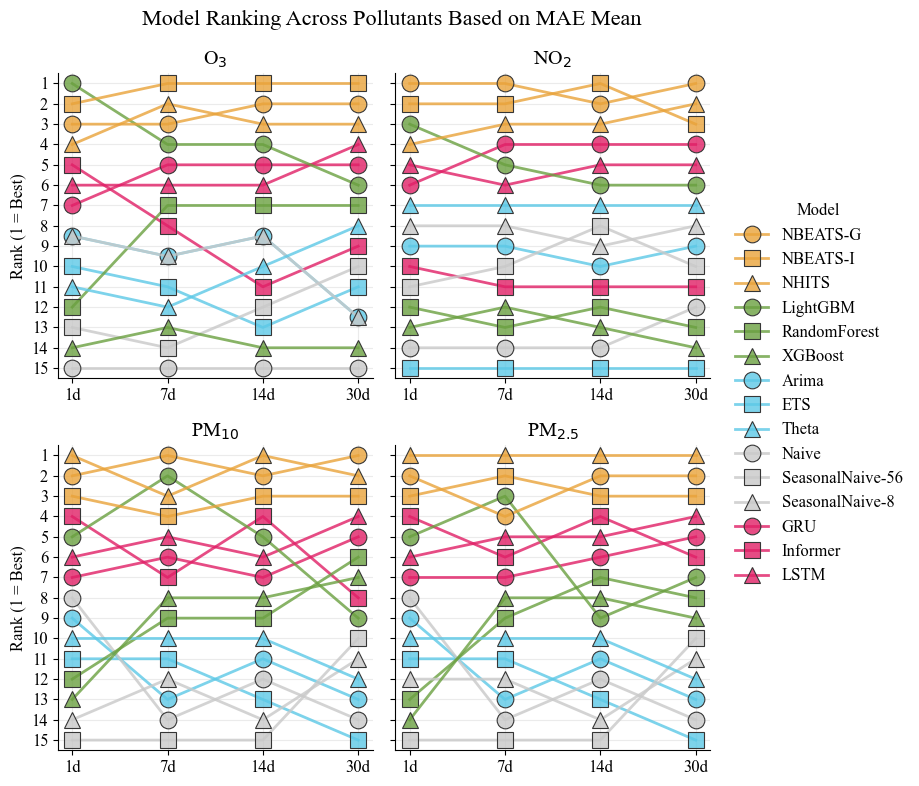

In [ ]:
def plot_bump_all_pollutants(metrics, pollutants, metric="MAE", agg_func: str = 'mean'):

    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 12
    })

    model_category = {
        'NHITS': 'Neural',
        'NBEATS-I': 'Neural',
        'NBEATS-G': 'Neural',
        'LightGBM': 'ML',
        'RandomForest': 'ML',
        'XGBoost': 'ML',
        'Theta': 'Stats',
        'Arima': 'Stats',
        'ETS': 'Stats',
        'Naive': 'Benchmark',
        'SeasonalNaive-8': 'Benchmark',
        'SeasonalNaive-56': 'Benchmark',
        'GRU': 'dl',
        'LSTM': 'dl',
        'Informer': 'dl',
    }

    color_map = {
        'Neural': "#e9a33acc",
        'ML': '#6aa040cc',
        'Stats': '#5cc8e6cc',
        'Benchmark': "#c9c9c9cc",
        'dl': "#e01f66cc",
        'Other': '#000000'
    }

    category_markers = ['o', 's', '^']

    # ==============================
    # PREPARE DATA (once)
    # ==============================

    df = (
        metrics
        .groupby(["pollutant", "horizon", "model"], observed=False)[metric]
        .agg(agg_func)
        .reset_index()
    )

    df["horizon"] = df["horizon"].str.replace("days", "", regex=False)
    df["horizon"] = df["horizon"].astype(int)

    horizons = sorted(df["horizon"].unique())
    horizon_labels = [f"{h}d" for h in horizons]
    x_numeric = np.arange(len(horizons))

    # ==============================
    # CREATE SUBPLOTS
    # ==============================

    fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
    axes = axes.flatten()

    handles = []
    labels = []

    for ax, pollutant in zip(axes, pollutants):

        pollutant_display = {
            "no2": r"NO$_2$",
            "pm10": r"PM$_{10}$",
            "pm2p5": r"PM$_{2.5}$",
            "go3": r"O$_{3}$",
        }

        df_pol = df[df["pollutant"] == pollutant].copy()
        df_pol = df_pol.sort_values("horizon")

        df_pol["rank"] = (
            df_pol
            .groupby("horizon", observed=False)[metric]
            .rank(method="average", ascending=True)
        )

        df_bump = (
            df_pol[["model", "horizon", "rank"]]
            .pivot(index="horizon", columns="model", values="rank")
            .reindex(horizons)
        )

        models = df_bump.columns.tolist()
        category_counter = {}

        for model in models:

            category = model_category.get(model, "Other")
            color = color_map.get(category, "#000000")

            if category not in category_counter:
                category_counter[category] = 0

            marker = category_markers[
                category_counter[category] % len(category_markers)
            ]
            category_counter[category] += 1

            y = df_bump[model].values

            line, = ax.plot(
                x_numeric,
                y,
                label=model,
                color=color,
                linewidth=2,
                marker=marker,
                markersize=12,
                markeredgecolor="#363636",
                markeredgewidth=0.8
            )

            # capture legend only once
            if pollutant == pollutants[0]:
                handles.append(line)
                labels.append(model)

        ax.set_title(pollutant_display.get(pollutant, pollutant.upper()))

        ax.set_xticks(x_numeric)
        ax.set_xticklabels(horizon_labels)
        ax.invert_yaxis()
        ax.grid(alpha=0.25)
        ax.spines[["top", "right"]].set_visible(False)

    max_rank = int(
        df.groupby(["pollutant", "horizon"], observed=False)[metric]
        .rank(method="average", ascending=True)
        .max()
    )
    for ax in axes:
        ax.set_ylim(max_rank + 0.5, 0.5)  # força 1 no topo
        ax.set_yticks(range(1, max_rank + 1))

    axes[0].set_ylabel("Rank (1 = Best)")
    axes[2].set_ylabel("Rank (1 = Best)")
    
    # Define ordem desejada das categorias
    category_order = {
        "Neural": 0,
        "ML": 1,
        "Stats": 2,
        "Benchmark": 3,
        "Other": 4
    }

    # Cria lista combinada
    legend_items = list(zip(handles, labels))

    # Ordena baseado na categoria do modelo
    legend_items.sort(
        key=lambda x: category_order.get(model_category.get(x[1], "Other"), 4)
    )

    # Separa novamente
    handles_sorted, labels_sorted = zip(*legend_items)

    fig.legend(
        handles_sorted,
        labels_sorted,
        title="Model",
        bbox_to_anchor=(0.91, 0.5),
        loc="center left",
        frameon=False
    )

    fig.suptitle(
        f"Model Ranking Across Pollutants Based on {metric} {agg_func.capitalize()}",
        fontsize=16,
        y=0.98
    )

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    
    # # SALVAR A IMAGEM AQUI
    # plt.savefig(
    #     "ranking_poluentes.png", 
    #     dpi=600,               # Altíssima resolução
    #     bbox_inches='tight',    # Garante que a legenda lateral não seja cortada
    #     facecolor='white',      # Fundo branco (evita transparência indesejada)
    #     transparent=False
    # )

    plt.show() # O show vem depois do savefig

    return fig, axes

plot_bump_all_pollutants(
    metrics,
    pollutants=["go3", "no2", "pm10", "pm2p5"],
    metric="MAE", 
    agg_func='mean'
);

## Ranking Bubble Plot

In [ ]:
metrics_ = metrics.copy()

# ==========================================
# NOVO: FILTRO DE MODELOS
# ==========================================
# Liste aqui apenas os modelos que você quer que apareçam
models_to_keep = [
    'NHITS', 'NBEATS-G', 'NBEATS-I', 
    'GRU', 'LSTM', 'Informer',
    'LightGBM', 'RandomForest', 'XGBoost',
    'Arima', 'ETS', 'Theta',
    'Naive', 'SeasonalNaive-8', 'SeasonalNaive-56',
] 

# Aplicando o filtro
metrics_ = metrics_[metrics_['model'].isin(models_to_keep)]
# ==========================================

# 1. Mapeamento EXATO e Internacionalização das Categorias
model_to_group = {
    'NHITS': 'Neural', 'NBEATS-G': 'Neural', 'NBEATS-I': 'Neural',
    'LightGBM': 'ML', 'RandomForest': 'ML', 'XGBoost': 'ML',
    'Arima': 'Statistical', 'ETS': 'Statistical', 'Theta': 'Statistical',
    'Naive': 'Benchmark', 'SeasonalNaive-56': 'Benchmark', 'SeasonalNaive-8': 'Benchmark',
    'GRU': 'dl', 'LSTM': 'dl', 'Informer': 'dl',
}
# ... o restante do seu código segue igual

group_colors = {
    'Neural': "#e9a33a",
    'ML': "#6aa040",
    'Statistical': '#5cc8e6',
    'Benchmark': "#C9C9C9",
    'dl': "#e01f66",
}

# Gerando o ranking
metrics_['ranking'] = metrics_.groupby(['pollutant', 'horizon', 'unique_id', 'cutoff'])['MAE'].rank(method='dense', ascending=True)
metrics_ = metrics_.groupby(['horizon', 'model', 'ranking']).agg({
    'pollutant': 'count'
}).reset_index()

# 2. Mapeando Grupos e Cores
metrics_['group'] = metrics_['model'].map(model_to_group)
metrics_['color'] = metrics_['group'].map(group_colors)

# 3. Ordenação dos Modelos (Neural -> ML -> Statistical -> Benchmark)
group_order = ['Neural', 'dl', 'ML', 'Statistical', 'Benchmark',]
metrics_['group'] = pd.Categorical(metrics_['group'], categories=group_order, ordered=True)
metrics_ = metrics_.sort_values(by=['group', 'model'], ascending=[False, True])

# Ordenação dos Horizontes
horizon_order = ['1days', '7days', '14days', '30days']
unique_horizons = [h for h in horizon_order if h in metrics_['horizon'].unique()]

figs = []

for horizon in unique_horizons:
    horizon_data = metrics_[metrics_['horizon'] == horizon]
    
    fig_item = go.Figure()
    fig_item.add_trace(go.Scatter(
        x=horizon_data['ranking'], 
        y=horizon_data['model'], 
        mode='markers+text', # ATUALIZADO: markers + texto
        name=horizon,
        marker=dict(
            size=70 * horizon_data['pollutant'] / horizon_data['pollutant'].max() if not horizon_data.empty else 10, 
            color=horizon_data['color'],
            opacity=0.7,
            line=dict(width=0.8, color='black')
        ),
        text=horizon_data['pollutant'], # ATUALIZADO: Mostra a contagem
        textposition="middle center",   # Centraliza o número na bolha
        textfont=dict(
            family="Times New Roman",
            size=10,
            color="black"
        )
    ))
    
    fig_item.update_yaxes(categoryorder='array', categoryarray=metrics_['model'].unique()[::-1])
    figs.append(fig_item)

# Gerando o subplot final
fig_final = plotlymodex.subplot(
    figs=figs, 
    title='Model Ranking Distribution by Forecasting Horizon',
    cols=2, rows=2,
    height=1100, width=1300,
    shared_yaxes=True,
    subplot_titles=['1-Day-Ahead Forecasting', '7-Days-Ahead Forecasting', 
                    '14-Days-Ahead Forecasting', '30-Days-Ahead Forecasting'],
    horizontal_spacing=0.05, 
    legends=[0, 0, 0, 0]
)

# ===============================
# PUBLICATION STYLE ADJUSTMENTS
# ===============================

fig_final.update_layout(
    font=dict(family="Times New Roman", size=15, color="black"),
    title=dict(font=dict(size=22)),
    plot_bgcolor='white'
)

# X Range fixado para clareza
max_rank = metrics_['ranking'].max() + 0.5

fig_final.update_xaxes(
    range=[0.1, max_rank+0.4], 
    title_text="Ranking Position", 
    dtick=1, 
    showgrid=True, 
    gridcolor='rgba(0,0,0,0.1)',
    linecolor='black',
    mirror=True
)

for i in [1, 2]:
    fig_final.layout[f'xaxis{i}'].title.text = ""

fig_final.update_yaxes(
    title_text=None,
    showgrid=True,
    gridcolor='rgba(0,0,0,0.05)',
    linecolor='black',
    mirror=True
)

fig_final.update_layout(margin=dict(l=120, r=40, t=70, b=60))

fig_final.show()

In [ ]:
metrics_ = metrics.copy()

# ==========================================
# NOVO: FILTRO DE MODELOS
# ==========================================
models_to_keep = [
    'NHITS', 'NBEATS-G', 'NBEATS-I', 
    'LightGBM', 
    'GRU', 'LSTM', 'Informer',
    'Arima', 'ETS', 'Theta',
] 

metrics_ = metrics_[metrics_['model'].isin(models_to_keep)]

# 1. Mapeamento EXATO e Internacionalização das Categorias
model_to_group = {
    'NHITS': 'Neural', 'NBEATS-G': 'Neural', 'NBEATS-I': 'Neural',
    'LightGBM': 'ML', 'RandomForest': 'ML', 'XGBoost': 'ML',
    'Arima': 'Statistical', 'ETS': 'Statistical', 'Theta': 'Statistical',
    'GRU': 'dl', 'LSTM': 'dl', 'Informer': 'dl',
}

group_colors = {
    'Neural': "#e9a33a",
    'ML': "#7cb153",
    'Statistical': '#5cc8e6',
    'Benchmark': "#C9C9C9",
    'dl': "#e94983",
}

# Gerando o ranking
metrics_['ranking'] = metrics_.groupby(['pollutant', 'horizon', 'unique_id', 'cutoff'])['MAE'].rank(method='dense', ascending=True)

# Agrupando contagens
metrics_ = metrics_.groupby(['horizon', 'model', 'ranking']).agg({
    'pollutant': 'count'
}).reset_index()

# CORREÇÃO: NORMALIZAÇÃO POR MODELO (SOMA 100%)
metrics_['rel_freq'] = metrics_.groupby(['horizon', 'model'])['pollutant'].transform(lambda x: (x / x.sum()) * 100)

# 2. Mapeando Grupos e Cores
metrics_['group'] = metrics_['model'].map(model_to_group)
metrics_['color'] = metrics_['group'].map(group_colors)

# 3. Ordenação dos Modelos
group_order = ['Neural', 'dl', 'ML', 'Statistical', 'Benchmark']
metrics_['group'] = pd.Categorical(metrics_['group'], categories=list(reversed(group_order)), ordered=True)
metrics_ = metrics_.sort_values(by=['group', 'model'], ascending=[False, True])

# --- NOVO: MAPEAMENTO PARA TÍTULOS ELEGANTES ---
horizon_display_names = {
    '1days': '1 Day',
    '7days': '7 Days',
    '14days': '14 Days',
    '30days': '30 Days'
}

# Ordenação dos Horizontes
horizon_order = ['1days', '7days', '14days', '30days']
unique_horizons = [h for h in horizon_order if h in metrics_['horizon'].unique()]

for horizon in unique_horizons:
    horizon_data = metrics_[metrics_['horizon'] == horizon]
    
    # Busca o nome formatado para o título
    title_horizon = horizon_display_names.get(horizon, horizon)
    
    fig_item = go.Figure()
    
    fig_item.add_trace(go.Scatter(
        x=horizon_data['ranking'], 
        y=horizon_data['model'], 
        mode='markers+text',
        name=horizon,
        marker=dict(
            size=70 * horizon_data['pollutant'] / horizon_data['pollutant'].max(), 
            color=horizon_data['color'],
            opacity=0.7,
            line=dict(width=0.8, color='black')
        ),
        text=horizon_data['rel_freq'].round(1).astype(str) + '%',
        textposition="middle center",
        textfont=dict(family="Times New Roman", size=11, color="black")
    ))

    fig_item.update_yaxes(categoryorder='array', categoryarray=metrics_['model'].unique()[::-1],
                         showgrid=True, gridcolor='rgba(0,0,0,0.05)', linecolor='black', mirror=True)
    
    max_rank = metrics_['ranking'].max() + 0.5
    fig_item.update_xaxes(range=[0.1, max_rank + 0.4], title_text="Ranking Position", dtick=1,
                         showgrid=True, gridcolor='rgba(0,0,0,0.1)', linecolor='black', mirror=True)

    fig_item.update_layout(
        title=f'Model Ranking Distribution - Horizon: {title_horizon}', # Título corrigido aqui
        font=dict(family="Times New Roman", size=15, color="black"),
        title_font=dict(size=22),
        plot_bgcolor='white',
        margin=dict(l=40, r=10, t=40, b=60),
        showlegend=False,
        height=550, width=750
    )

    fig_item.show()
    # filename = f"bubbleplot_h{horizon}.png"
    # fig_item.write_image(filename, scale=3)

print("\nConferência de soma das linhas (deve ser 100.0 para todos os modelos):")
print(metrics_.groupby(['horizon', 'model'])['rel_freq'].sum().unstack(level=0))


Conferência de soma das linhas (deve ser 100.0 para todos os modelos):
horizon   14days  1days  30days  7days
model                                 
Arima      100.0  100.0   100.0  100.0
ETS        100.0  100.0   100.0  100.0
GRU        100.0  100.0   100.0  100.0
Informer   100.0  100.0   100.0  100.0
LSTM       100.0  100.0   100.0  100.0
LightGBM   100.0  100.0   100.0  100.0
NBEATS-G   100.0  100.0   100.0  100.0
NBEATS-I   100.0  100.0   100.0  100.0
NHITS      100.0  100.0   100.0  100.0
Theta      100.0  100.0   100.0  100.0


In [560]:
def get_top_n_table(df, r=3):
    """
    Gera uma tabela com a soma das frequências relativas até o ranking 'r'.
    """
    # Filtramos apenas os modelos que estão nas posições 1 até r
    top_n_data = df[df['ranking'] <= r].copy()
    
    # Somamos a frequência relativa (rel_freq) para cada modelo em cada horizonte
    table = top_n_data.groupby(['horizon', 'model'])['rel_freq'].sum().reset_index()
    
    # Pivotamos para que os horizontes virem colunas (estilo relatório)
    pivot_table = table.pivot(index='model', columns='horizon', values='rel_freq')
    
    # Reordenar colunas conforme sua lista de horizontes (se existirem no DF)
    horizon_order = ['1days', '7days', '14days', '30days']
    cols = [h for h in horizon_order if h in pivot_table.columns]
    pivot_table = pivot_table[cols]
    
    # Preencher modelos que talvez não tenham aparecido no top N com 0%
    pivot_table = pivot_table.fillna(0).sort_values('30days', ascending=False)
    
    # Adicionar o sufixo % para facilitar a leitura
    formatted_table = pivot_table.map(lambda x: f"{x:.1f}%")
    
    return formatted_table

# --- EXEMPLO DE USO ---

# Para o Top 3 (como você pediu inicialmente)
print("--- TOP 3 PERFORMANCE ---")
df_top3 = get_top_n_table(metrics_, r=3)
display(df_top3)
df_top3.to_excel(r'3.xlsx')

# Para o Top 5 (conforme sua necessidade de variar)
print("\n--- TOP 5 PERFORMANCE ---")
df_top5 = get_top_n_table(metrics_, r=5)
display(df_top5)
df_top5.to_excel(r'5.xlsx')

--- TOP 3 PERFORMANCE ---


horizon   1days  7days 14days 30days
model                               
NBEATS-G  39.1%  47.0%  53.8%  53.5%
NHITS     35.2%  48.7%  49.9%  52.1%
NBEATS-I  35.5%  44.5%  50.9%  49.7%
GRU       23.2%  28.5%  26.5%  37.1%
LSTM      25.0%  24.6%  26.4%  34.6%
LightGBM  43.1%  36.6%  35.8%  28.2%
Theta     24.0%  20.8%  18.7%  15.6%
ETS       24.4%  16.5%  15.7%  13.0%
Arima     23.2%  16.2%  10.7%   8.8%
Informer  27.4%  16.6%  11.6%   7.5%


--- TOP 5 PERFORMANCE ---


horizon   1days  7days 14days 30days
model                               
NBEATS-G  69.9%  75.2%  80.5%  83.8%
NBEATS-I  66.8%  73.9%  80.8%  82.7%
NHITS     67.6%  81.5%  82.7%  81.9%
GRU       41.4%  50.9%  52.7%  67.8%
LSTM      43.2%  48.4%  52.8%  67.7%
LightGBM  63.2%  58.8%  55.8%  43.2%
Theta     34.9%  33.6%  28.5%  25.5%
ETS       35.3%  25.6%  23.0%  20.2%
Arima     32.2%  23.4%  18.7%  14.2%
Informer  45.6%  28.8%  24.5%  13.0%

## Metric BoxPlot

In [538]:
def plot_boxplot_metrics(horizons: list = ['1', '7', '14', '30'], 
                         metric: str = 'sMAPE',
                         models: list = None,
                         colors: list = ["#B3C7F9", "#6B8EF6", "#365FCE", "#1D2E91"],
                         x_range: list = [0, 30e-9],
                         metric_title: str = None,
                         boxmean: str = 'sd'):

    # ===============================
    # DATA PREPARATION
    # ===============================
    df_plot = metrics.dropna(subset=[metric])

    if models:
        df_plot = df_plot[df_plot['model'].isin(models)]

    df_plot = df_plot[df_plot['horizon'].isin([f'{h}days' for h in horizons])]

    # ===============================
    # COLOR SCALE
    # ===============================
    horizon_color_map = {str(h): colors[i] for i, h in enumerate(horizons)}

    # ===============================
    # BOXPLOT
    # ===============================
    box_data = []

    # Removido o reversed para a legenda seguir a ordem natural 1 -> 30
    for horizon_idx, horizon in enumerate(list(reversed(horizons))): 
        horizon_data = df_plot[df_plot['horizon'] == f'{horizon}days']
        
        current_color = horizon_color_map[horizon]

        box_data.append(
            go.Box(
                x=horizon_data[metric],
                y=horizon_data['model'],
                name=f'{horizon}days',
                boxmean=boxmean,
                # Define a cor da CAIXA e das linhas (whiskers/median)
                line=dict(color=current_color),
                # Define a cor apenas dos PONTOS (outliers)
                marker=dict(
                    color='lightgrey', 
                    opacity=0.5, 
                    size=7
                ),
                orientation='h',
                pointpos=0,
                offsetgroup=horizon_idx,
                boxpoints='suspectedoutliers',
                jitter=0.1,
            )
        )

    # ===============================
    # LAYOUT
    # ===============================
    fig = go.Figure(data=box_data)

    fig.update_layout(
        title=f'Boxplot of {metric} by Model and Horizon',
        xaxis_title=f'{metric}',
        yaxis_title=None,
        boxmode='group',
        boxgap=0.25,
        boxgroupgap=0.1,
        font=dict(family="Times New Roman", size=16),
        # Fixando range em 0 para o SD não vazar para o negativo
        xaxis=dict(
            showgrid=True, 
            gridwidth=0.4, 
            dtick=0.1, 
            gridcolor="rgba(0,0,0,0.03)",
            range=[0, None] 
        ),
        yaxis=dict(
            showgrid=False, 
            showticklabels=True, 
            autorange=True, 
            categoryorder='array',
            categoryarray=models  # Garantir a ordem dos modelos conforme o input
        ), 
        margin=dict(l=100, r=40, t=50, b=60),
        showlegend=True,
    )

    if metric_title is None:
        metric_title = metric

    # Caso use o seu wrapper personalizado:
    if 'plotlymodex' in globals():
        plotlymodex.main_layout(
            fig, title=f'Boxplot of {metric_title} by Model and Horizon',
            width=1000, height=900,
            x=f'{metric_title}', y=None,
            x_range=x_range,
            # x_type='log'
        )
    
    return fig

In [ ]:
fig = plot_boxplot_metrics(
    ['1', '7', '14', '30'], 
    models=[
        'Informer', 
        'Theta', 
        'LightGBM', 
        'GRU', 
        'LSTM',
        'NBEATS-I', 'NBEATS-G', 'NHITS', 
    ],  
    metric='Skill_MAE', 
    # colors=plotlymodex.list_colors(n=4, colors=["#ebafe3", "#b93349", "#6d0707"], weights=[0, 0.7, 1]),
    # colors=plotlymodex.list_colors(n=4, colors=["#afd6eb", "#336db9", "#073f6d"], weights=[0, 0.7, 1]),
    colors=["#55b85a", "#e4ddd1", "#d1e6e4", "#ac3880"],
    x_range=[0, 1], 
    metric_title='MAE Skill Score',
    boxmean=True,
)

fig.show()
# filename = f"boxplot_skill_MAE.png"
# fig.write_image(filename, scale=3)

## Geographical Consistency

In [136]:
def get_rankings_table(metrics, metric="MAE", agg_func='mean'):
    """
    Gera uma tabela de rankings por poluente, horizonte e unique_id.
    
    Args:
        metrics: DataFrame original com as métricas.
        metric: A métrica a ser avaliada (ex: 'MAE', 'RMSE').
        agg_func: Função de agregação (caso haja múltiplas previsões para o mesmo id/horizonte).
    """
    
    # 1. Agrupar os dados incluindo o unique_id
    # O observed=False garante que categorias vazias não quebrem o código se usar tipos Categorical
    df_ranks = (
        metrics
        .groupby(["pollutant", "horizon", "unique_id", "model"], observed=False)[metric]
        .agg(agg_func)
        .reset_index()
    )

    # 2. Calcular o Ranking
    # Agrupamos por pollutant, horizon e unique_id. 
    # O rank é calculado entre os modelos dentro de cada um desses grupos.
    df_ranks["ranking"] = (
        df_ranks
        .groupby(["pollutant", "horizon", "unique_id"], observed=False)[metric]
        .rank(method="min", ascending=True) # method="min" dá rank 1, 2, 2, 4 em caso de empate
    )

    # 3. Ordenação para facilitar a leitura
    df_ranks = df_ranks.sort_values(["pollutant", "horizon", "unique_id", "ranking"])

    return df_ranks

# Exemplo de uso:
df_final = get_rankings_table(metrics, metric="MAE")

# Se quiser ver apenas os "Top 1" de cada série:
# top_1 = df_final[df_final['ranking'] == 1]
df_final = df_final.merge(
    pd.read_csv(r'..\Data\CAMS\processed\unique_id_info.csv'),
    on='unique_id', how='left'
)
df_final.to_csv('RQ1_results.csv', index=False)

In [ ]:
df_final.query("pollutant == 'go3' and model == 'NHITS'")

pollutant horizon  unique_id  model           MAE  ranking  unique_id.1  \
2          go3  14days         54  NHITS  8.857477e-09      3.0           54   
16         go3  14days         59  NHITS  9.113837e-09      2.0           59   
33         go3  14days         60  NHITS  9.018170e-09      4.0           60   
47         go3  14days         61  NHITS  8.760082e-09      3.0           61   
62         go3  14days         62  NHITS  8.952121e-09      3.0           62   
...        ...     ...        ...    ...           ...      ...          ...   
1906       go3   7days         91  NHITS  9.346436e-09      2.0           91   
1922       go3   7days         92  NHITS  9.334769e-09      3.0           92   
1938       go3   7days        102  NHITS  8.538828e-09      4.0          102   
1951       go3   7days        103  NHITS  8.651461e-09      2.0          103   
1965       go3   7days        104  NHITS  8.721071e-09      1.0          104   

      latitude  longitude  code_state abbrev_state name_state  code_region  \
2       -26.50     -52.00        41.0           PR     Paraná          4.0   
16      -25.75     -53.50        41.0           PR     Paraná          4.0   
33      -25.75     -52.75        41.0           PR     Paraná          4.0   
47      -25.75     -52.00        41.0           PR     Paraná          4.0   
62      -25.75     -51.25        41.0           PR     Paraná          4.0   
...        ...        ...         ...          ...        ...          ...   
1906    -23.50     -50.50        41.0           PR     Paraná          4.0   
1922    -23.50     -49.75        41.0           PR     Paraná          4.0   
1938    -22.75     -52.75        41.0           PR     Paraná          4.0   
1951    -22.75     -52.00        41.0           PR     Paraná          4.0   
1965    -22.75     -51.25        41.0           PR     Paraná          4.0   

     name_region  
2            Sul  
16           Sul  
33           Sul  
47           Sul  
62           Sul  
...          ...  
1906         Sul  
1922         Sul  
1938         Sul  
1951         Sul  
1965         Sul  

[132 rows x 14 columns]

In [135]:
print(df_final)

     pollutant horizon  unique_id             model           MAE  ranking  \
0          go3  14days         54          NBEATS-G  8.803132e-09      1.0   
1          go3  14days         54          NBEATS-I  8.818827e-09      2.0   
2          go3  14days         54             NHITS  8.857477e-09      3.0   
3          go3  14days         54          LightGBM  9.009477e-09      4.0   
4          go3  14days         54               GRU  9.286260e-09      5.0   
...        ...     ...        ...               ...           ...      ...   
7915     pm2p5   7days        104               ETS  5.612660e-09     11.0   
7916     pm2p5   7days        104   SeasonalNaive-8  5.946158e-09     12.0   
7917     pm2p5   7days        104             Arima  6.212270e-09     13.0   
7918     pm2p5   7days        104             Naive  6.212270e-09     13.0   
7919     pm2p5   7days        104  SeasonalNaive-56  7.658565e-09     15.0   

      unique_id.1  latitude  longitude  code_state abbrev_state

# **RQ2**